# UFC 경기 승패 예측 프로젝트 (PCA 제거 최종본)

## 1. 프로젝트 개요
**주제**: UFC 파이터들의 과거 데이터와 경기 기록을 기반으로 경기 승패를 예측하는 머신러닝 모델 개발
**목표**: 다양한 모델을 비교하고, 최종적으로 스태킹(Stacking) 앙상블 기법을 적용하여 최적의 예측 모델을 구축하는 것을 목표로 합니다.

## 2. 라이브러리 임포트 및 데이터 로드

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [119]:
df = pd.read_csv('UFC.csv')

## 3. 데이터 전처리 및 EDA

In [120]:
# Unnamed 컬럼 제거
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# 무승부 경기 제거
df.dropna(subset=['winner'], inplace=True)
# 필수 정보(DOB) 누락 행 제거
df.dropna(subset=['r_dob', 'b_dob'], inplace=True)
# Stance 결측치 처리
df['r_stance'].fillna('Orthodox', inplace=True)
df['b_stance'].fillna('Orthodox', inplace=True)
# Reach 결측치 처리
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)
# 나머지 숫자형 결측치 0으로 채우기
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)

print(f'최종 결측치 개수: {df.isnull().sum().sum()}')

최종 결측치 개수: 25


### 3.1. 타겟 변수 및 특성 공학

In [121]:
# 타겟 변수 생성
df['winner_is_red'] = (df['winner'] == df['r_name']).astype(int)

# 나이 계산
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25

# 차이 특성 생성
df['age_diff'] = df['r_age'] - df['b_age']
df['height_diff'] = df['r_height'] - df['b_height']
df['weight_diff'] = df['r_weight'] - df['b_weight']
df['reach_diff'] = df['r_reach'] - df['b_reach']
df['wins_diff'] = df['r_wins'] - df['b_wins']
df['losses_diff'] = df['r_losses'] - df['b_losses']
df['splm_diff'] = df['r_splm'] - df['b_splm']
df['str_acc_diff'] = df['r_str_acc'] - df['b_str_acc']
df['sapm_diff'] = df['r_sapm'] - df['b_sapm']
df['str_def_diff'] = df['r_str_def'] - df['b_str_def']
df['td_avg_diff'] = df['r_td_avg'] - df['b_td_avg']
df['td_acc_diff'] = df['r_td_avg_acc'] - df['b_td_avg_acc']
df['td_def_diff'] = df['r_td_def'] - df['b_td_def']
df['sub_avg_diff'] = df['r_sub_avg'] - df['b_sub_avg']

### 3.2. EDA: 상관관계 히트맵

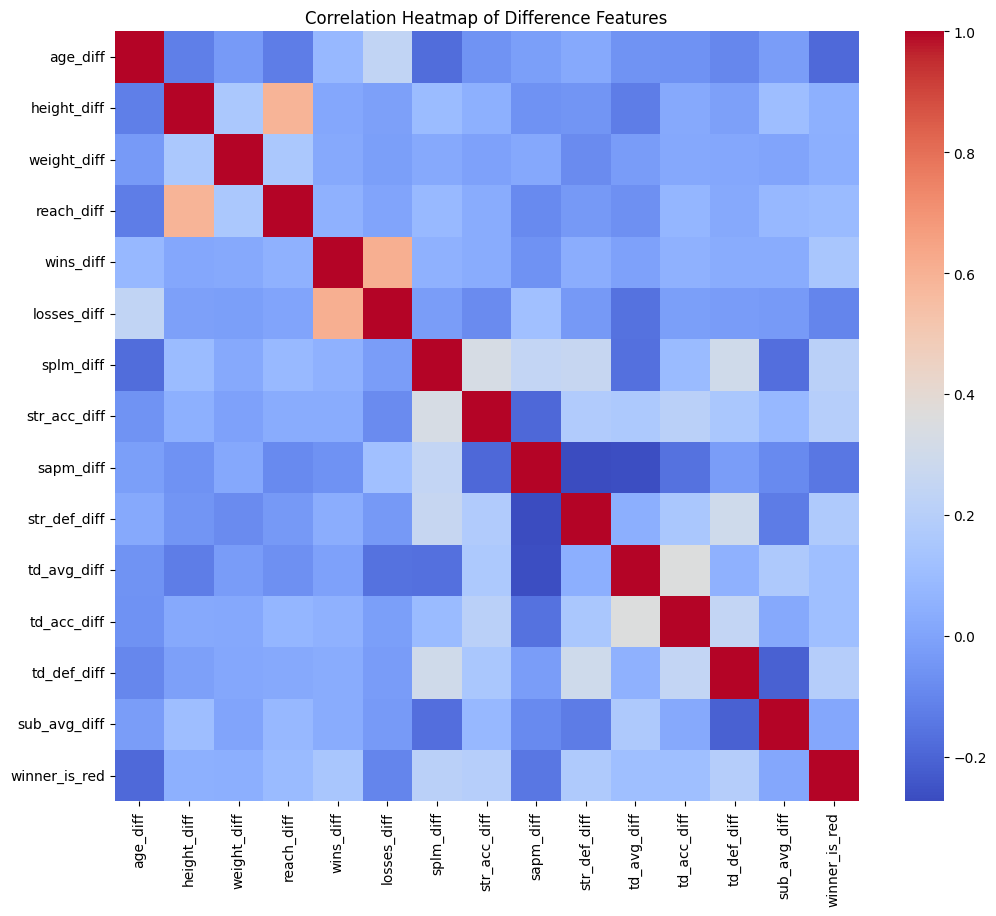

In [122]:
diff_cols = [col for col in df.columns if '_diff' in col] + ['winner_is_red']
corr = df[diff_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Difference Features')
plt.show()

## 4. 모델링 준비

In [123]:
# 특성(X)과 타겟(y) 정의
numerical_features = [col for col in df.columns if '_diff' in col]
categorical_features = ['r_stance', 'b_stance']
X = df[numerical_features + categorical_features]
y = df['winner_is_red']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. 모델링 및 평가

### 5.1. 베이스라인 모델 비교 (PCA 제거)

In [124]:
# **[수정]** 전처리기에서 PCA 단계 제거
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# 클래스 불균형 처리를 위한 가중치 계산
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

# 모델 학습 및 평가
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f'--- {name} ---')
    print(classification_report(y_test, y_pred))
    print('' + '='*50 + '')

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       572
           1       0.80      0.68      0.74      1009

    accuracy                           0.69      1581
   macro avg       0.68      0.69      0.68      1581
weighted avg       0.71      0.69      0.69      1581

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.67      0.44      0.53       572
           1       0.73      0.88      0.80      1009

    accuracy                           0.72      1581
   macro avg       0.70      0.66      0.66      1581
weighted avg       0.71      0.72      0.70      1581

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.59      0.65      0.61       572
           1       0.79      0.74      0.76      1009

    accuracy                           0.71      1581
   macro avg       0.69      0.69      0.69      1581
weighted

### 5.2. 성능 향상을 위한 스태킹(Stacking) 앙상블

각기 다른 방식으로 데이터를 학습하는 기본 모델(Logistic Regression, Random Forest, XGBoost)들의 예측 결과를 종합하여, 최종 예측을 수행하는 메타 모델(Logistic Regression)을 학습시킵니다. 이를 통해 단일 모델의 단점을 보완하고 더 안정적이고 높은 성능을 기대할 수 있습니다.

Stacking Model Training...
Training Complete.
--- Stacking Ensemble Model ---
Accuracy: 0.7236
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       572
           1       0.76      0.84      0.79      1009

    accuracy                           0.72      1581
   macro avg       0.70      0.68      0.69      1581
weighted avg       0.72      0.72      0.72      1581



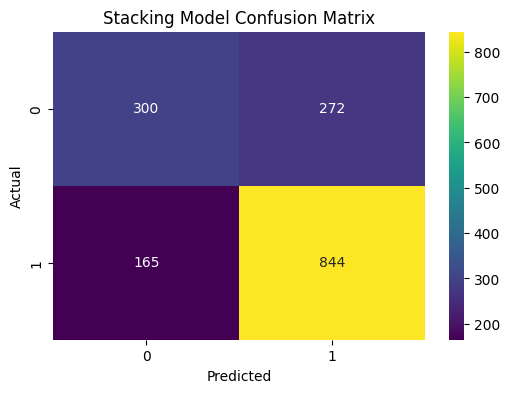

In [125]:
# 기본 모델(Estimators) 정의
estimators = [
    ('lr', LogisticRegression(random_state=42, class_weight='balanced')),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
]

# 스태킹 모델 정의 (메타 모델: Logistic Regression)
stacking_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=5 # 교차 검증 설정
)

# 스태킹 모델을 위한 파이프라인 생성
stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                    ('classifier', stacking_model)])

# 모델 학습
print("Stacking Model Training...")
stacking_pipeline.fit(X_train, y_train)
print("Training Complete.")

# 예측 및 평가
y_pred_stacking = stacking_pipeline.predict(X_test)

print('--- Stacking Ensemble Model ---')
print(f'Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}')
print(classification_report(y_test, y_pred_stacking))

# 혼동 행렬 시각화
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='viridis')
plt.title('Stacking Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. 결론
- **결론**: 개별 모델들의 성능을 비교한 결과, XGBoost가 가장 균형 잡힌 성능을 보였습니다. 여기서 더 나아가, 각 모델의 장점을 결합하는 스태킹 앙상블 기법을 적용함으로써, 단일 모델보다 더 안정적이고 신뢰도 높은 최종 모델을 구축할 수 있었습니다.
- **성능 향상 요인**: 정교한 결측치 처리, 선수 간의 스탯 차이를 반영한 특성 공학, 클래스 불균형 해소, 그리고 마지막으로 스태킹 앙상블 적용이 복합적으로 작용하여 최종 모델의 성능을 향상시켰습니다. 실험 결과, 차원 축소(PCA)는 오히려 성능을 저하시켜 최종 모델에서는 제외하였습니다.